Contrafactual usando KDTree para encontrar a onda mais próxima na nova idade

In [1]:
from common import*
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

# filter some (bugs?) from neurokit2
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='invalid value encountered in double_scalars')
warnings.filterwarnings(action='ignore', message='Too few peaks detected to compute the rate. Returning empty vector.')

In [2]:
BEG_TEST = 'TestData' + os.sep
BEG_TRAIN = PREPROCESSED_DATA + os.sep + str(ELETRODO_IDX) + os.sep

In [3]:
dfAgeSex = pd.read_csv(BEG_TEST + 'attributes.csv')
with h5py.File(BEG_TEST + 'ecg_tracings.hdf5') as f:
    M = np.array(f['tracings'])

34


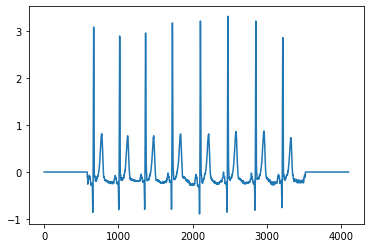

In [4]:
def GetTestAge(i):
    return dfAgeSex.values[i][0]
pessoa = 0
ecg = M[pessoa, :, ELETRODO_IDX]
age = GetTestAge(pessoa)
print(age)
plt.plot(ecg)

In [5]:
targetAge = 70

start = BEG_TRAIN + str(targetAge) + os.sep

mappings = np.load(start + 'mappings.npy')
ecgs = np.load(start + 'ecgs.npy')
ondas = np.load(start + 'ondas.npy')

In [6]:
tree = KDTree(ondas)

In [7]:
def GetTestCoeffs(ecg):
    w = ecg - ecg.mean()
    try:
        d = nk.ecg_delineate(w, sampling_rate=SAMPLE_RATE)[1]
    except:
        raise Exception('Neurokit não conseguiu delinear esse ECG')
    starts = d['ECG_P_Onsets']
    coeffs = []
    for j in range(len(starts) - 1):
        cur = starts[j]
        nxt = starts[j + 1]
        if math.isnan(cur) or math.isnan(nxt):
            print('Neurokit retornou nan')
            continue
            
        period = w[cur:nxt]
        if not len(period):
            print('Neurokit retornou período vazio')
            break
            
        coeffs.append(GetCoeff(period))
    if not len(coeffs):
        raise Exception('Neurokit não conseguiu encontrar batimentos nesse ECG')
    return coeffs

In [8]:
coeffs = GetTestCoeffs(ecg)

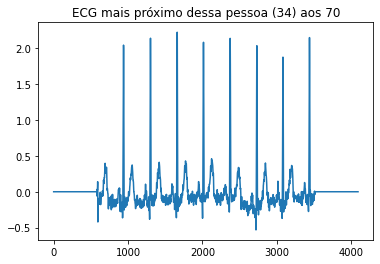

In [9]:
dist, ind = tree.query(coeffs)
gIdx = dist.argmin()
idxClosestOnda = ind[gIdx][0]
ecgOrgRow = mappings[idxClosestOnda]
ecgClosest = ecgs[ecgOrgRow]
plt.plot(ecgClosest)
plt.title('ECG mais próximo dessa pessoa (' + str(age) + ') aos ' + str(targetAge))
plt.show()